# Project description

Gene expression profile is the measurement of the activity (the expression) of thousands of genes in a sample. The internal patterns of the GEPs such as coexpression of large clusters of genes suggest that the dimensionality of GEPs can be significantly reduced. I am going to use a variety of dimension reduction techniques to see if this can really be accomplished, and to compare these techniques' suitability for this task.

For the purpose of this project, I consider the reconstruction mean squared error as the measure to compare different methods. In other words, For each method, I first reduce the dimension and then try to reconstruct the input using the reduced data. Finally I compute MSE between the reconstructed and original data and use it as the measure to compare methods for the task at hand.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda, Dropout, BatchNormalization
from keras.models import Model
from keras import optimizers, regularizers, callbacks
from keras.activations import sigmoid, softplus
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Load data

`data.txt` contains normalized expression profiles of 20184 genes in 1040 samples of 16 different human tissues and cell types from different datasets of NCBI GEO, which were collected and preprocessed in CellNet. `SampleCellTypes.txt` contains the type of the cell samples present in `data.txt`.

Load the data using the command below:

In [ ]:
data = pd.read_csv("data.txt", header=None)
labels = pd.read_csv("SampleCellTypes.txt", header=None)
labels = [label[0] for label in labels.values]

# Cell Type Distribution

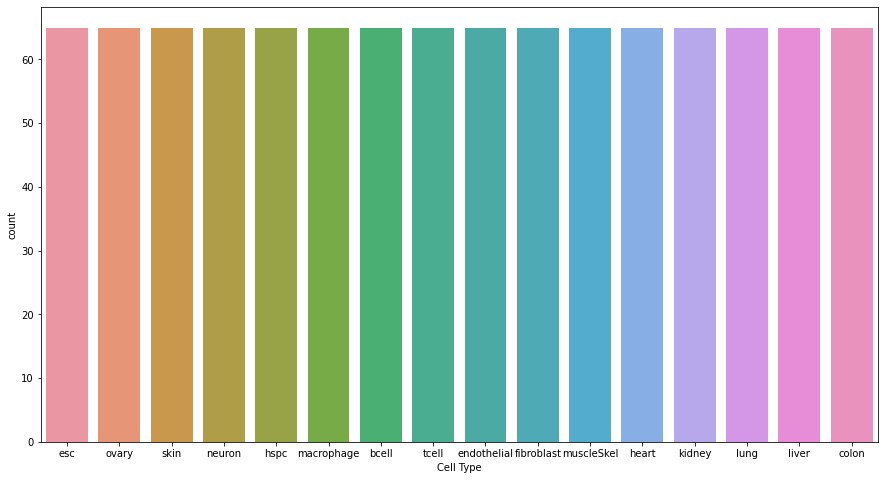

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x=labels)
plt.xlabel('Cell Type');

Number of samples from each cell type in the dataset is always the same. Therefore, I can use a measure like accuracy to evaluate the classification performance.

# Variable selection

To reduce the computation costs, instead of working on all 20184 genes present in the dataset, I will focus on 1000 genes that have the most variance.

In [ ]:
limited_data = data[data.var().sort_values(ascending=False)[:1000].index]

# Data preperation

Let's split the data to train and test with a ratio of 3:1.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    limited_data, 
    labels, 
    test_size=0.25,
    random_state=42,
    stratify=labels
)

# Dimension Reduction

I will use a latent space of dimension 30 for all the dimension reduction methods.

In [ ]:
latent_space_dim = 30

## PCA

In [ ]:
pca = PCA(n_components=latent_space_dim)
pca.fit(X_train)


pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)

reconstructed_train = pca.inverse_transform(pca_train)
reconstructed_test = pca.inverse_transform(pca_test)


train_pca_error = mean_squared_error(X_train, reconstructed_train) # Mean Squared Error
test_pca_error = mean_squared_error(X_test, reconstructed_test)

In [ ]:
print(f'Train MSE: {round(train_pca_error, 3)}\nTest MSE: {round(test_pca_error, 3)}')

Train MSE: 0.355
Test MSE: 0.411


## Classification over PCA space

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(pca_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
np.mean(clf.predict(pca_test) == y_test)

0.9884615384615385

# Paper's Auto Encoder

In [ ]:
input_data = Input(shape=(1000,))
encoded = input_data
encoded = Dense(300)(encoded)
encoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(encoded)
encoded = Dense(30)(encoded)

decoded = encoded
decoded = Dense(300)(decoded)
decoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(decoded)
decoded = Dense(1000)(decoded)

In [ ]:
autoencoder = Model(input_data, decoded)
sgd = optimizers.SGD(lr=0.02)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                        patience=5, min_lr=0.001)
autoencoder.compile(optimizer=sgd, loss='mean_squared_error')

history = autoencoder.fit(X_train.to_numpy(), X_train.to_numpy(),
                epochs=200,
                batch_size=5,
                callbacks=[reduce_lr],
                shuffle=True,
                validation_data=(X_test.to_numpy(), X_test.to_numpy()))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
156/156 [==============================] - 3s 12ms/step - loss: 5.3987 - val_loss: 3.8016 - lr: 0.0200
Epoch 2/200
156/156 [==============================] - 2s 10ms/step - loss: 3.1025 - val_loss: 2.5547 - lr: 0.0200
Epoch 3/200
156/156 [==============================] - 1s 9ms/step - loss: 2.2414 - val_loss: 1.9955 - lr: 0.0200
Epoch 4/200
156/156 [==============================] - 2s 11ms/step - loss: 1.8945 - val_loss: 1.7542 - lr: 0.0200
Epoch 5/200
156/156 [==============================] - 2s 11ms/step - loss: 1.6349 - val_loss: 1.6416 - lr: 0.0200
Epoch 6/200
156/156 [==============================] - 2s 11ms/step - loss: 1.4995 - val_loss: 1.4243 - lr: 0.0200
Epoch 7/200
156/156 [==============================] - 2s 10ms/step - loss: 1.3721 - val_loss: 1.3174 - lr: 0.0200
Epoch 8/200
156/156 [==============================] - 1s 9ms/step - loss: 1.2692 - val_loss: 1.3066 - lr: 0.0200
Epoch 9/200
156/156 [==============================] - 1s 8ms/step - loss: 1.1818 

In [ ]:
print('Train MSE is: 0.3932')
print('Test MSE is: 0.4685')

Train MSE is: 0.3932
Test MSE is: 0.4685


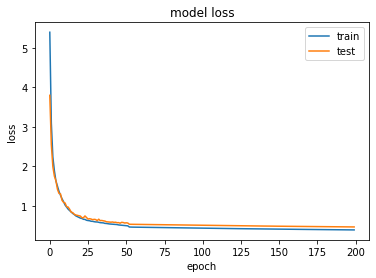

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# Deeper Auto Encoders

In [ ]:
input_data = Input(shape=(1000,))
encoded = input_data
encoded = Dense(400)(encoded)
encoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(encoded)
encoded = Dense(100)(encoded)
encoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(encoded)
encoded = Dense(30)(encoded)

decoded = encoded
decoded = Dense(100)(decoded)
decoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(decoded)
decoded = Dense(400)(decoded)
decoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(decoded)
decoded = Dense(1000)(decoded)

In [ ]:
autoencoder = Model(input_data, decoded)
sgd = optimizers.SGD(lr=0.02)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                        patience=5, min_lr=0.001)
autoencoder.compile(optimizer=sgd, loss='mean_squared_error')

history = autoencoder.fit(X_train.to_numpy(), X_train.to_numpy(),
                epochs=300,
                batch_size=5,
                callbacks=[reduce_lr],
                shuffle=True,
                validation_data=(X_test.to_numpy(), X_test.to_numpy()))

Epoch 1/300
156/156 [==============================] - 3s 12ms/step - loss: 2.7615 - val_loss: 2.3400 - lr: 0.0200
Epoch 2/300
156/156 [==============================] - 2s 12ms/step - loss: 2.1288 - val_loss: 2.0089 - lr: 0.0200
Epoch 3/300
156/156 [==============================] - 1s 9ms/step - loss: 1.8794 - val_loss: 1.7406 - lr: 0.0200
Epoch 4/300
156/156 [==============================] - 1s 8ms/step - loss: 1.7222 - val_loss: 1.7346 - lr: 0.0200
Epoch 5/300
156/156 [==============================] - 1s 8ms/step - loss: 1.5548 - val_loss: 1.7010 - lr: 0.0200
Epoch 6/300
156/156 [==============================] - 2s 10ms/step - loss: 1.4611 - val_loss: 1.3891 - lr: 0.0200
Epoch 7/300
156/156 [==============================] - 2s 13ms/step - loss: 1.3668 - val_loss: 1.3101 - lr: 0.0200
Epoch 8/300
156/156 [==============================] - 2s 12ms/step - loss: 1.2838 - val_loss: 1.2322 - lr: 0.0200
Epoch 9/300
156/156 [==============================] - 1s 7ms/step - loss: 1.1956 -

In [ ]:
print('Train MSE is: 0.3836')
print('Test MSE is: 0.4676')

Train MSE is: 0.3836
Test MSE is: 0.4676


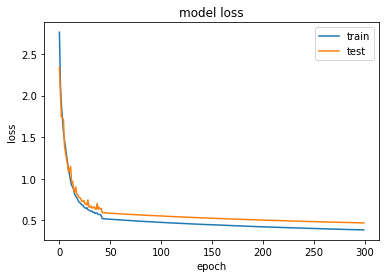

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Less Deep Auto Encoders

In [ ]:
input_data = Input(shape=(1000,))
encoded = input_data
encoded = Dense(100)(encoded)
encoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(encoded)
encoded = Dense(30)(encoded)

decoded = encoded
decoded = Dense(100)(decoded)
decoded = Lambda(lambda x: tf.math.log(sigmoid(x) + 1e-10))(decoded)
decoded = Dense(1000)(decoded)

In [ ]:
autoencoder = Model(input_data, decoded)
sgd = optimizers.SGD(lr=0.02)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                        patience=5, min_lr=0.001)
autoencoder.compile(optimizer=sgd, loss='mean_squared_error')

history = autoencoder.fit(X_train.to_numpy(), X_train.to_numpy(),
                epochs=300,
                batch_size=5,
                callbacks=[reduce_lr],
                shuffle=True,
                validation_data=(X_test.to_numpy(), X_test.to_numpy()))

Epoch 1/300
156/156 [==============================] - 1s 4ms/step - loss: 5.3883 - val_loss: 3.9202 - lr: 0.0200
Epoch 2/300
156/156 [==============================] - 0s 3ms/step - loss: 3.8321 - val_loss: 3.4769 - lr: 0.0200
Epoch 3/300
156/156 [==============================] - 0s 3ms/step - loss: 3.1400 - val_loss: 2.5702 - lr: 0.0200
Epoch 4/300
156/156 [==============================] - 0s 3ms/step - loss: 2.4393 - val_loss: 2.1833 - lr: 0.0200
Epoch 5/300
156/156 [==============================] - 0s 3ms/step - loss: 2.0273 - val_loss: 3.0672 - lr: 0.0200
Epoch 6/300
156/156 [==============================] - 0s 3ms/step - loss: 1.8237 - val_loss: 1.8354 - lr: 0.0200
Epoch 7/300
156/156 [==============================] - 1s 3ms/step - loss: 1.7025 - val_loss: 1.6649 - lr: 0.0200
Epoch 8/300
156/156 [==============================] - 1s 3ms/step - loss: 1.5736 - val_loss: 1.5142 - lr: 0.0200
Epoch 9/300
156/156 [==============================] - 1s 4ms/step - loss: 1.4880 - val_

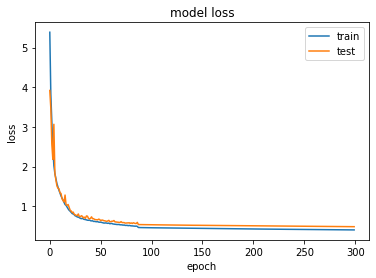

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Ensemble Classification

In [ ]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = GaussianNB()
ensemble_classifier = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

In [ ]:
ensemble_classifier = ensemble_classifier.fit(pca_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
np.mean(ensemble_classifier.predict(pca_test) == y_test)

0.9923076923076923

In [ ]:
I tried to improve the auto encoder by changing its architecture. 
I tried a deeper auto encoder and also a shallower one. 
Non of them improved the papers reported mean squared error. 


So I used an ensemble method for the classification part and improved the test accuracy to 99.2%.